In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import Fluka_dump_tools as fdt

In [46]:
# User inputs

# Path to the Feather file
feather_file = "~/Desktop/phiKK/phiKK_4550_MeV_7883_files.ftr"

# outpute LHE file name
output_name = "phiKK_4550_MeV_7883.lhe"

# output directory
output_dir = "/Users/mghrear/Desktop/phiKK_4550_MeV_7883"

In [3]:
# Create a DataFrame from feather_file
df = pd.read_feather(feather_file)

# Keep only 2nd gen events with one K+ and one K- in the secondaries
# Very few events have multiple K+ or K- in the secondaries, but they creat amibiguities about which K+/K- combo comes from the same phi decay 
df['Kflag'] = df.IDs.apply(lambda x: np.count_nonzero(x == 16) == 1)
df['Kflag2'] = df.IDs.apply(lambda x: np.count_nonzero(x == 15) == 1)
df_phiKK = df.loc[(df.Kflag == True)&(df.Kflag2 == True) ].reset_index(drop=True)


Text(0, 0.5, 'Counts')

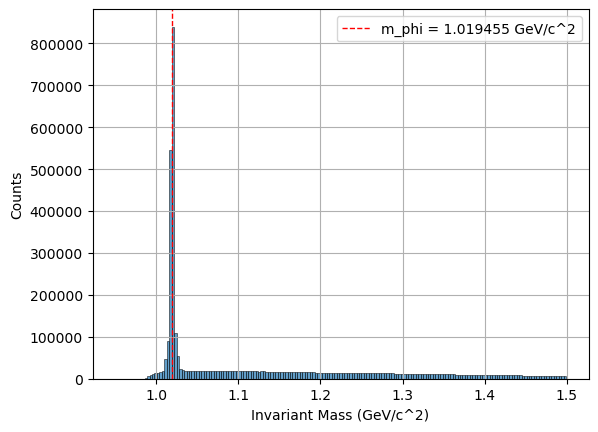

In [4]:
# Visualize the invariant mass distribtution

# mass of kaon
mK = 0.493677
# mass of the phi meson
m_phi = 1.019455

# Get the momentum and energy of the kaons
df_phiKK['PKm'] = df_phiKK.apply(lambda row: np.array([row.dir_xs[row.IDs == 16].item(),row.dir_ys[row.IDs == 16].item(),row.dir_zs[row.IDs == 16].item()])*row.Ps[row.IDs == 16].item() , axis=1)
df_phiKK['PKp'] = df_phiKK.apply(lambda row: np.array([row.dir_xs[row.IDs == 15].item(),row.dir_ys[row.IDs == 15].item(),row.dir_zs[row.IDs == 15].item()])*row.Ps[row.IDs == 15].item() , axis=1)
df_phiKK['EKm'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 16].item()**2 / ( mK**2 + row.Ps[row.IDs == 16].item()**2 ) )) , axis=1)
df_phiKK['EKp'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 15].item()**2 / ( mK**2 + row.Ps[row.IDs == 15].item()**2 ) )) , axis=1)

# Calculate the invariant mass 
df_phiKK['M']= df_phiKK.apply(lambda row: np.sqrt((row.EKp+row.EKm)**2 - (row.PKm+row.PKp).dot(row.PKm+row.PKp)) , axis=1)

# Plot the invariant mass distribution of the K+K- pair

# mass of the phi meson
m_phi = 1.019455

df_phiKK.M.hist(bins=np.arange(0.95, 1.5, 0.003), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 

Text(0, 0.5, 'Counts')

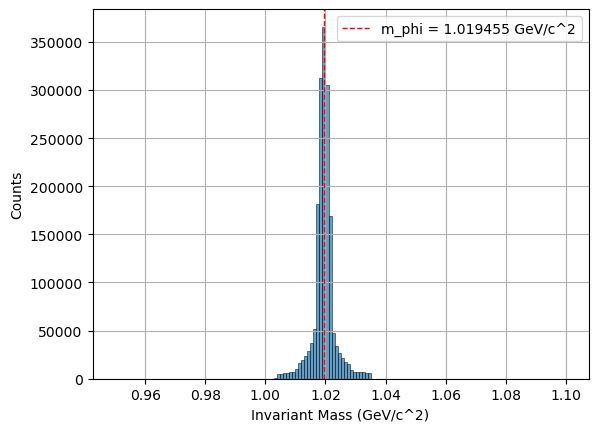

In [5]:
# Make a selection around the phi mass, for now we take these as phi-> K+ K-  events
selec_window = 0.0155

df_phiKK_cut = df_phiKK.loc[(df_phiKK.M > m_phi-selec_window) & (df_phiKK.M < m_phi+selec_window)].reset_index(drop=True)

df_phiKK_cut.M.hist(bins=np.arange(0.95, 1.1, 0.001), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 

In [6]:
# Collect the unique FLUKA IDs for all secondaries in selected events
unique_fluka_ids_df = df_phiKK_cut.explode('IDs')['IDs'].unique()

# Check if all FLUKA IDs are present in the flukaIDdict
keys_view = fdt.flukaIDdict.keys() 
keys_list = np.array(list(keys_view))
missing_keys = np.setdiff1d(unique_fluka_ids_df, keys_list)
if len(missing_keys) > 0:
    print("Error add the following fluka IDs to flukaIDdict: ", missing_keys)
else:
    # Use the fluka IDs and flukaIDdict to convert the IDs to PDG IDs, secondary mass, and charge 
    df_phiKK_cut[['PDG_IDs', 'Sec_mass', 'Sec_charge']] = df_phiKK_cut['IDs'].apply(fdt.convert_fluka_ids).apply(pd.Series)

In [47]:
def write_lhe_files(df, output_dir, output_name, events_per_file = 10000 , include_recoil_e = True, include_other_secondaries = False, elastic_only = False):

    # Filter events if only eleastic events are requested
    if elastic_only:
        df = df.loc[( (df.ProjID == 7) & (df.NoSecondary == 2) ) | ( (df.ProjID == 3) & (df.NoSecondary == 3) )].reset_index(drop=True)

    # Split the DataFrame into smaller DataFrames for writing to LHE files
    num_dfs = int(np.ceil(len(df_phiKK_cut) / events_per_file))
    dfs = []
    for my_index in np.arange(0, num_dfs, 1):
        df_i = df_phiKK_cut.iloc[my_index*events_per_file:(my_index+1)*events_per_file].reset_index(drop=True)

        # Create lhe file
        file = open(output_dir+'/'+output_name+"_"+str(my_index), "w")

        # Constants for the LHE file
        rscale = 1.740000e+02 
        alpha_EM = 7.297353e-03
        alpha_QCD = 1.078706E-01 
        beam_energy = 4.5

        #Write header 
        file.write(f"\n")
        file.write(f"<LesHouchesEvents version=\"3.0\">\n")
        file.write(f"<header>\n")
        file.write(f"#  Number of Events        :       "+str(len(df_i))+"\n")
        file.write(f"</header>\n")

        # Write the init block
        file.write(f"<init>\n")
        file.write(f"{11} {623} {beam_energy:.6e} {rscale:.6e} {0} {0} {0} {0} {0} {1}\n")
        file.write("0 0 0 1\n")
        file.write(f"</init>\n")


        # Loop through the DataFrame to write the event blocks
        for index, row in df_i.iterrows():

            # Start event block
            file.write(f"<event>\n")

            # There are two caes:
            # Case 1: ProjID == 7 (incoming particle is a photon)
            # In this case, the recoil electron is omitted and must be inferred from the momentum of the incoming photon
            if row.ProjID == 7:

                if include_other_secondaries and include_recoil_e:
                    file.write(f"{1+row['NoSecondary']:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")

                elif include_other_secondaries and (include_recoil_e == False):
                    file.write(f"{row['NoSecondary']:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
                    
                elif (include_other_secondaries == False) and (include_recoil_e):
                    file.write(f"{3:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
                else:
                    file.write(f"{2:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")

                # Infer the recoil electron from the incoming photon if requested
                if include_recoil_e:
                    file.write(f"{11:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{-row.ProjkE*row.ProjdirX:>+18.10e}{-row.ProjkE*row.ProjdirY:>+18.10e}{beam_energy-row.ProjkE*row.ProjdirZ:>+18.10e}{beam_energy-row.ProjkE:>17.10e}{5.11E-4:>17.10e}{0:>11.4e} {1:>.4e}\n")

                # Now include the secondaries
                for PDG_ID, P, x, y, z, m, c in zip(row.PDG_IDs,row.Ps,row.dir_xs,row.dir_ys,row.dir_zs, row.Sec_mass, row.Sec_charge):

                    # Inlcude all secondaries if requested
                    if include_other_secondaries:
                        if m != 0:  #If it's not a Photon E= m/sqrt(1-P^2/(P^2 + m^2))
                            file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{m/np.sqrt(1-P**2/(m**2+P**2)):>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")
                        else:       #If it is a Photon E = P 
                            file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{P:>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")
                    
                    # If all secondaries are not requested then only include the charged kaons
                    elif (PDG_ID == 321) or (PDG_ID == -321):
                        file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{m/np.sqrt(1-P**2/(m**2+P**2)):>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")

            # Case 2: ProjID == 3 (incoming particle is a electron)
            # In this case, the recoil electron is the first secondary that is listed
            elif row.ProjID == 3:

                if include_other_secondaries and include_recoil_e:
                    file.write(f"{row['NoSecondary']:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")

                elif include_other_secondaries and (include_recoil_e == False):
                    file.write(f"{row['NoSecondary']-1:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
                    
                elif (include_other_secondaries == False) and (include_recoil_e):
                    file.write(f"{3:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
                else:
                    file.write(f"{2:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")

                # Now include the secondaries
                sec_counter = 0
                for PDG_ID, P, x, y, z, m, c in zip(row.PDG_IDs,row.Ps,row.dir_xs,row.dir_ys,row.dir_zs, row.Sec_mass, row.Sec_charge):

                    # The first secondary is the recoil electron, either skip it or write it
                    if sec_counter == 0:
                        if include_recoil_e:
                            file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{m/np.sqrt(1-P**2/(m**2+P**2)):>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")
                            sec_counter += 1
                            continue
                        else:
                            sec_counter += 1
                            continue
                    
                    sec_counter += 1

                    # Inlcude all secondaries if requested
                    if include_other_secondaries:
                        if m != 0:  #If it's not a Photon E= m/sqrt(1-P^2/(P^2 + m^2))
                            file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{m/np.sqrt(1-P**2/(m**2+P**2)):>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")
                        else:       #If it is a Photon E = P 
                            file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{P:>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")
                    
                    # If all secondaries are not requested then only include the charged kaons
                    elif (PDG_ID == 321) or (PDG_ID == -321):
                        file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{m/np.sqrt(1-P**2/(m**2+P**2)):>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")

            # end event block
            file.write(f"</event>\n")

        file.write(f"</LesHouchesEvents>")
        file.close()
        print("LHE written to: ", output_dir+'/'+output_name+"_"+str(my_index))


In [48]:
write_lhe_files(df_phiKK_cut, output_dir, output_name, events_per_file = 10000, include_recoil_e = True, include_other_secondaries = False, elastic_only = False)

LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_0
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_1
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_2
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_3
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_4
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_5
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_6
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_7
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_8
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_9
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_MeV_7883/phiKK_4550_MeV_7883.lhe_10
LHE written to:  /Users/mghrear/Desktop/phiKK_4550_Me